# Credit Card Anomaly Detection Models
    Brainstation Data Science Capstone | 2019 | Manny Brar

#### Objective=
The importance of effective and quick detection of fraud events is becoming more and more essential everyday with the rise in fraud activity over the years. For my project I have decided to explore and evaluate a few different machine learning classification models to see which model will have the highest accuracy to detect anomaly transactions. I will utilize both supervised and unsupervised methods and compare overall performance metrics to determine the best option.

#### Data=
This dataset was downloaded from Kaggle, and consists of european credit card data from September 2013, that occured over a span of 2 days. This dataset contains over 250,000 transactions and contains only numerical values and 31 columns. Among these columns we have columns v1-v28 containing private and sensitive data that has been pre-processed with PCA transformations. Due to confidentiality reasons this data has been transformed into numerical values. We also have a 'Time' column and this data represents the time in seconds from the first transaction to the current. The 'Amount' column provides a monetary value for each transaction and finally we have a 'Class' column which is a binary column with a value of 0 representing a legitimate transaction and a value of 1 to represent a anomaly or 'fraud' event.

Source=
(https://www.kaggle.com/mlg-ulb/creditcardfraud)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import sklearn


^^^ To start we import some of the tools and libraries we know we will probably use.

In [3]:
cred = pd.read_csv('creditcard.csv')
cred.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


^^^ We now read and set the dataset as cred and display the first 5 rows in order to view a sample of the data.

In [4]:
cred.shape

(284807, 31)

^^^ Here we continue to get a perspective on the size and shape of the data and we can see here that we have 284,807 rows and 31 columns. The features including: Time(Time between the first transaction and the current), Amount(The monetary value of each transaction), Class(Using one hot encoding, 0 represents legitimate transaction and 1 represents an anomaly or a 'fraudulent' transaction, we can also see that we have features ranging from v1-v28 and using PCA transformation the information is transformed into new features due to sensitive information)

In [5]:
cred.isnull().values.any()

False

^^^ Here we check for any missing data using the 'isnull' method to check if we have any missing data, and we can see that we do not have any missing values. (If we did have missing values we could use cred.isnull().sum() to seem how many missing values in each column)

In [6]:
anomaly_df = cred.loc[cred['Class'].isin([1])]
anomaly_df.shape

(492, 31)

^^^ Here we assign anomaly_df to include only transactions that contain a value of 1 in the 'Class' column. Further we want to see the number of transactions that contain a 1 in the 'Class' column by using the .shape method. The data tells us that 'Class' 1 is defined as an anomaly or fraudulent transaction and therefore we have 492 anomaly events out of a total 284,807 transactions. As a percentage the anomaly events make up only .172% of the total transactions. Making this a very unbalanced dataset, and being unbalanced we would want to take that into account when selecting classification models to test.

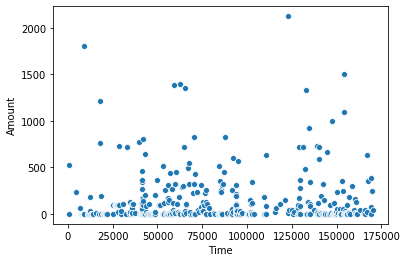

In [7]:
sns.scatterplot(data=anomaly_df, x='Time', y='Amount')

^^^ Here we visualize the fraudulent transactions with time on the x axis and amount on the y axis. From this we can see clearly that most of these amounts were well below 500. 

In [8]:
anomaly_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


^^^ We use the .describe() method to let us view the data form another angle. We are interested in the amount column and here we can see that the mean=122.21, standard deviation=256.68, minimum value=0 and maximum value=2125.87

In [9]:
legit_df = cred.loc[cred['Class'].isin([0])]
legit_df.shape

(284315, 31)

^^^ Now we take a look at the legitmate transactions. For this we extract all rows that have 0 as the value in the 'Class' column and assign it to legit_df. Once again we view the shape and can see that we have 284,315 legitimate transactions.

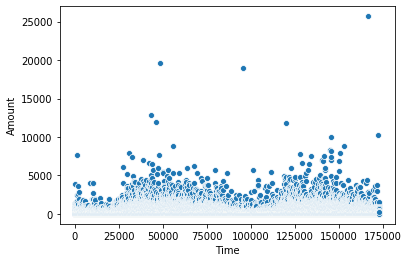

In [10]:
sns.scatterplot(data=legit_df, x='Time', y='Amount')

^^^ Now when we visualize this data, we can see that we have much larger amounts with legitimate transactions.

In [11]:
legit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


^^^ Now we use the describe method again to view information about our legit transactions and we can see the following: mean=88.29, standard deviation=250.10, minimum value=0 and maximum value=25,691.16.
We can understand a data a little better and we can see that although the mean is lower than the anomaly transactions, the maximum is much higher at over 25,000. Not only that but we can see when comparing with the anomaly data that the legitamate transactions are generally higher at the 25%, 50% marks however that is not true at the 75% mark. We can now determine that most anomaly transactions were less than 200 and infact to my surprise legit transactions were for the most part less than 100. 

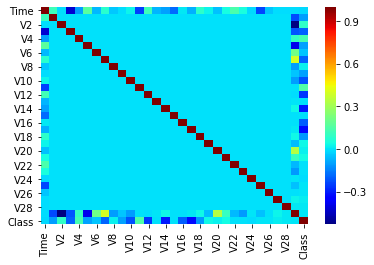

In [12]:
sns.heatmap(cred.corr(), cmap='jet')

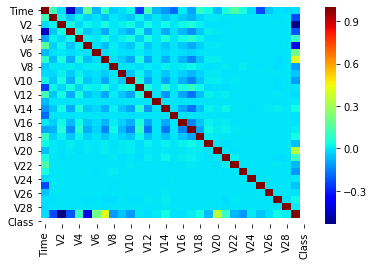

In [13]:
sns.heatmap(legit_df.corr(), cmap='jet')

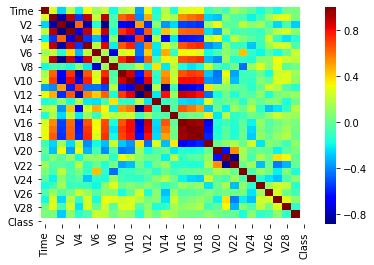

In [14]:
sns.heatmap(anomaly_df.corr(), cmap='jet')

^^^ Here I have 3 heatmaps showing the correlations between features. The first heatmap we have plotted the full dataset and can't see too much in regards to correlated features. In heatmap 2 we can see for legit transactions we can see once again very little correlation between features and even start to see some negative correlations. In the last heatmap we have only the anomaly data and we can see that some of these features between v1-v18 have some stronger positive and some stronger negative correlations. For example v12 and v16 have a strong positive correlation, as well as v16-v18 are all very positively correlated with each other. On the flip side v11 and v14 have a strong negative correlation. Also we see almost no positive or negative correlations from features v19-v28 with some small inconsistancies and variances.

In [22]:
sample_df = cred.sample(frac=.10, random_state=1)
sample_df.shape

(28481, 31)

^^^ Now we are ready to create a sample of the dataset and we are only taking 10% for our sample and then we can check the shape.

In [23]:
anomaly = sample_df[sample_df['Class']==1]
legit = sample_df[sample_df['Class']!=1]

outlier_fraction = len(anomaly)/float(len(legit))
print('Outlier Fraction:', outlier_fraction)
print('Anomaly Transactions:', len(anomaly))
print('Legit Transactions:', len(legit))

Outlier Fraction: 0.0017234102419808666
Anomaly Transactions: 49
Legit Transactions: 28432


^^^ We now determine how many anomaly transactions we have in our sample data set and can verify the outlier fraction.

In [24]:
columns = sample_df.columns.tolist()

columns = [c for c in columns if c not in ['Class']]

target= 'Class'

x= sample_df[columns]
y= sample_df[target]
print(x.shape)
print(y.shape)

(28481, 30)
(28481,)


^^^ Now I created independant and dependant features and filter out the columns to remove data we don't need. Then we store the 'Class' variable we are predicting.

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score

state=1

classifiers = {'Isolation Forest':IsolationForest(max_samples=len(x), contamination= outlier_fraction, random_state=state), 
                     'Local Outlier Factor': LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction)}

^^^ Here I have imported the classification models we would like to evaluate to see which model gives us the highest accuracy for predicted anomalies in our dataset. Through doing some research online I found out that some models perform better in situations with highly unbalanced data, like we have here and so I have chosen to utilize and evaluate the performance of the following models:

#### Isolation Forest= 
Returns anomaly score by a decision tree structure and randomly isolates a value and randomly splits value between min and max, and outliers get assigned a lower score.

#### Local Outlier Factor= 
Unsupervised outlier detection method, and it calculates the anomaly scores of each sample. It measures the local deviation of density in regards to it's neighbors. Scores depend on how isolated the value in respect to it's surrounding values. Similar to K-Nearest Neighbors

In [26]:
num_outliers = len(anomaly)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(x)
        scores_pred = clf.negative_outlier_factor_
        
    else:
        clf.fit(x)
        scores_pred = clf.decision_function(x)
        y_pred = clf.predict(x)
        
      # Reshape the prediction values to 0 for legit, 1 for anomaly. 
    y_pred[y_pred==1] = 0
    y_pred[y_pred==-1] = 1
    
    
    n_errors = (y_pred != y).sum()
    
    # Run classification metrics
    print(clf_name)
    print(n_errors)
    print(accuracy_score(y, y_pred))
    print(classification_report(y, y_pred))


C:\Users\manny\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\manny\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest
71
0.99750711000316
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28481
   macro avg       0.64      0.64      0.64     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor
97
0.9965942207085425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



^^^Here I wrote a for loop to run both models and print the classifier metrics. As we can see that the accuracy score for both models is relatively high and we might assume that both models are doing a fantastic job with accuracy scores of 99.75% for Isolation Forest and 99.65% for Local Outlier Factor. However when we take a closer look at other metrics we can see that we have perfect precision with both models when predicting the legit transactions, but when we look at precision for anomaly or 'fraud' transactions we see a very poor precision metric of 2% for the Local Outlier Factor model. The Isolated Forest model performs much better when predicting anomaly transactions, and jumps up in precision to 28%! This is a big jump and very meaningful insight. Although we had accuracy scores in the 99 percentile for both models, we can see the Local Outlier Factor performed very poorly in the precision metric. This is a clear result of our extremely unbalanced dataset, both models predicted the legit transaction perfectly and with only .174% of the data being anomaly events, we see a very high accuracy score. We can also see that the number of errors for Local Outlier Factor were 97 and Isolatation Forest improves upon that with 71 errors.

Although our Isolated Forest model is able to predict anomaly transactions at around 28% of the time. This is still not an ideal situation in the real world. I wanted to see if I could improve the precision scores for both legit and anomaly transactions and with Isolated Forest performing better than Local Outlier Factor, I wanted to build a model that was similar to Isolated Forest and decided to give Random Forest a try.

#### Random Forest= 
Operates as a large number of uncorrelated decision trees and randomly builds trees and creates a cluster of trees that offer accuracy using a large number of trees instead of only an individual tree.

In [27]:
from sklearn.ensemble import RandomForestClassifier

RandomForest= RandomForestClassifier(random_state=3)
RandomForest.fit(x, y)
y_pred=RandomForest.predict(x)
y_prob=RandomForest.predict_proba(x)[:,1]

num_errors=(y_pred != y).sum()

print('Accuracy:', accuracy_score(y, y_pred))
print('Number of errors:', num_errors)
print(classification_report(y, y_pred))


C:\Users\manny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9998244443664197
Number of errors: 5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       1.00      0.90      0.95        49

    accuracy                           1.00     28481
   macro avg       1.00      0.95      0.97     28481
weighted avg       1.00      1.00      1.00     28481



^^^ Here I implement the Random Forest model on our sample data and print the results. We can see that the accuracy has jumped up significantly to 99.99%! Not only that but we have a significant drop in number of errors at only 5 out of 28,481 transactions. Further more we can see that we now have perfect precision for both legit and anomaly or 'fraud' transactions! 

### Conclusion=
So in conclusion I was able to evaluate the performance metrics of 3 machine learning models on this highly unbalanced dataset. The approach would be different for each situation or problem you're trying to solve and for my project I wanted to explore which model would perform with the highest accuracy, not only that but I was able to determine that evaluating only one performance metric may not give you a complete picture of the data or the model performance. Instead it's important to really understand the type of data you are working with, your goals or the problem your are trying to solve and not to mention the strengths and weaknesses of different models in different situations. I was able to determine a clear cut winner out of the 3 models I utilized. The Random Forest model was superior in every performance metric I evaluated.